In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import pydicom
from utils import *
from IPython.display import HTML

In [21]:
# Load DICOM metadata
filename = r"DICOM_Files\DICOM_Files\US\20230616114956_013.DCM"
ds = pydicom.dcmread(filename)
print(ds)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 178
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Ultrasound Multi-frame Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113663.1500.1.378941928.3.13.20230616.114956.638
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1545.1
-------------------------------------------------
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'ABDOMINAL']
(0008,0012) Instance Creation Date              DA: '20230616'
(0008,0013) Instance Creation Time              TM: '114956'
(0008,0016) SOP Class UID                       UI: Ultrasound Multi-frame Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.840.113663.1500.1.378941928.3.13.20230616.114956.638
(0008,0020) 

In [28]:
# Check if the dataset is 3D/4D
if len(ds.SequenceOfUltrasoundRegions) == 3:
    private_data = ds[0x200D, 0x3016][1][0x200D, 0x300D].value

    if private_data == 'UDM_USD_DATATYPE_DIN_3D_ECHO':
        # Number of voxels and frames
        numberOfFrames = int(ds[0x200D, 0x3016][1][0x200D, 0x3020][0][0x200D, 0x3010].value)
        C_string = ds[0x200D, 0x3301].value
        C = [int(C_string[0]), int(C_string[1]), int(C_string[2]), numberOfFrames]
        print ("C: ", C)
        frame_size = np.prod(C[:3])
        print ("Frame Size: ",frame_size)

        # Voxel spacing
        scale_string = ds[0x200D, 0x3303].value
        trueFrameRate = float(ds[0x200D, 0x3207].value)
        scale = [float(scale_string[0]), float(scale_string[1]), float(scale_string[2]), trueFrameRate]
        print ("True Frame Rate: ", float(ds[0x200D, 0x3207].value))
        print ("Scale: ", scale)

        # Raw data
        raw_data = ds[0x200D, 0x3016][1][0x200D, 0x3020][0][0x200D, 0x300E].value
        print ("Raw data: ", len(raw_data))

        # Calculate interval
        total_data_points = len(raw_data)
        interval = (total_data_points - frame_size * C[3]) // C[3]
        print ("Interval: ", interval)

        # Construct 4D volume
        V = np.zeros((C[0], C[1], C[2], C[3]))
        start = 32  # Starting index

        for n in range(C[3]):
            start_idx = start + n * interval + n * frame_size
            end_idx = start_idx + frame_size
            V[:, :, :, n] = np.reshape(np.frombuffer(raw_data[start_idx:end_idx], dtype=np.uint8), (C[0], C[1], C[2]),order='F')

        # Apply scaling (optional)
        V = V / 10 * 2.5
        scale = scale[::-1]
        C = C[::-1]

# Now V is a 4D numpy array representing the 3D ultrasound data over time.


C:  [64, 202, 103, 59]
Frame Size:  1331584
True Frame Rate:  24.38786459857575
Scale:  [0.608329568972813, 0.3056708599202969, 0.6143691777539347, 24.38786459857575]
Raw data:  78571008
Interval:  128


In [30]:
print(V.shape)

(64, 202, 103, 59)


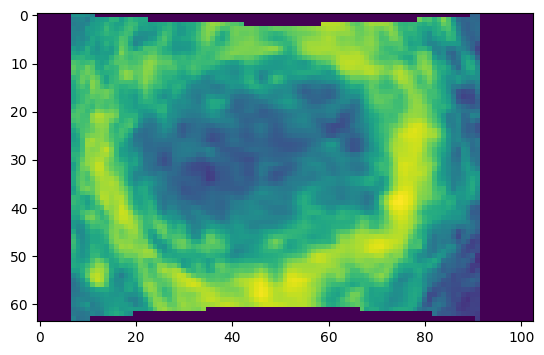

In [31]:
plt.imshow(V[:,150,:,0])

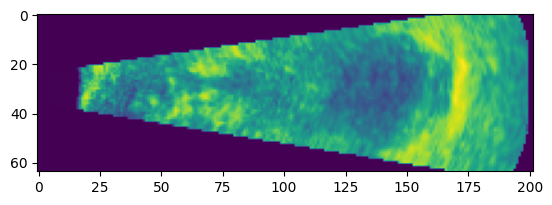

In [33]:
plt.imshow(V[:,:,50,0])

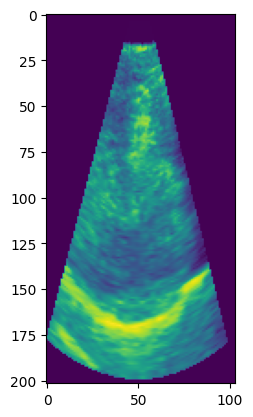

In [38]:
plt.imshow(V[36,:,:,0])